# Logistic Regression, Bayes and EM

## In this notebook you will see the following:
1. implementation of Logistic Regression algorithm.
1. implementation of EM algorithm.
1. implementation of Navie Bayes algorithm that uses EM for calculating the likelihood.
1. Visualizen of the results.

In [1]:
import numpy as np
import pandas as pd
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

# make matplotlib figures appear inline in the notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Make the notebook automatically reload external python modules
%load_ext autoreload
%autoreload 2
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Function for ploting the decision boundaries of a model
# You will use it later
def plot_decision_regions(X, y, classifier, resolution=0.01):

    # setup marker generator and color map
    markers = ('.', '.')
    colors = ('blue', 'red')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')

## Reading the data

In [3]:
training_set = pd.read_csv('training_set.csv')
test_set = pd.read_csv('test_set.csv')
X_training, y_training = training_set[['x1', 'x2']].values, training_set['y'].values
X_test, y_test = test_set[['x1', 'x2']].values, test_set['y'].values

## Visualizing the data

We will plot the following graphs for the training set:

For the first feature only:
1. For the first 1000 data points plot a histogram for each class on the same graph (use bins=20, alpha=0.5).
1. For all the data points plot a histogram for each class on the same graph (use bins=40, alpha=0.5).

For both features:
1. For the first 1000 data points plot a scatter plot where each class has different color
1. For all the data points plot a scatter plot where each class has different color

In [4]:
#### seperate by class & feature ####
class_1 = X_training[y_training == 1]
class_0 = X_training[y_training == 0]
class_1_first1000 = X_training[ : 1000][y_training[ : 1000] == 1]
class_0_first1000 = X_training[ : 1000][y_training[ : 1000] == 0]

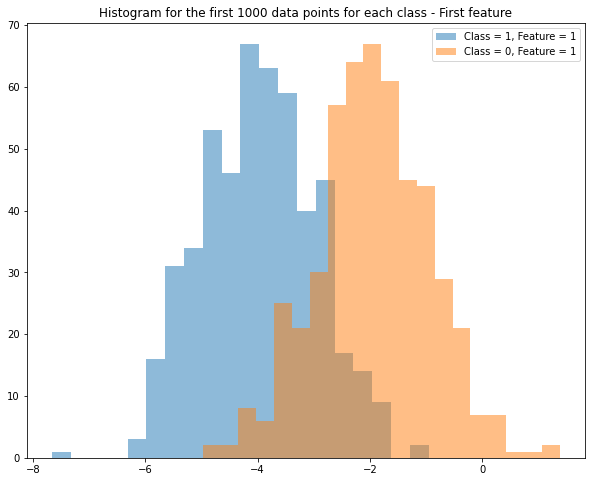

In [5]:
### Histogram for the first 1000 data points for each class - First feature ###
class_1_feature_0_first1000 = class_1_first1000[ : , 0]
class_0_feature_0_first1000 = class_0_first1000[ : , 0]

plt.hist(class_1_feature_0_first1000, bins = 20, alpha = 0.5, label = "Class = 1, Feature = 1")
plt.hist(class_0_feature_0_first1000, bins = 20, alpha = 0.5, label = "Class = 0, Feature = 1")
plt.title("Histogram for the first 1000 data points for each class - First feature") 
plt.legend()
plt.show()

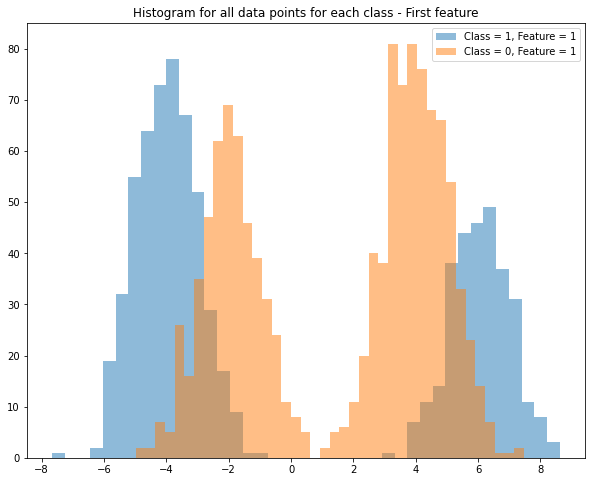

In [6]:
### Histogram for all data points for each class - First feature ###
class_1_feature_0 = class_1[ : , 0]
class_0_feature_0 = class_0[ : , 0]

plt.hist(class_1_feature_0, bins = 40, alpha = 0.5, label = "Class = 1, Feature = 1")
plt.hist(class_0_feature_0, bins = 40, alpha = 0.5, label = "Class = 0, Feature = 1")
plt.title("Histogram for all data points for each class - First feature") 
plt.legend()
plt.show()

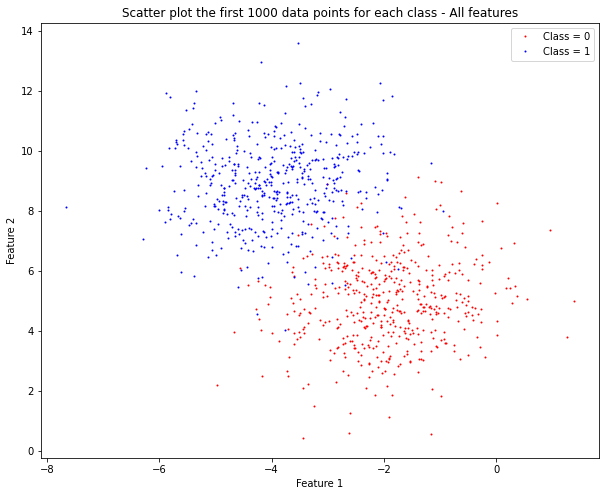

In [7]:
### Scatter plot for the first 1000 data points for each class - All features ###
class_1_feature_0_first1000 = class_1_first1000[ : , 0]
class_1_feature_1_first1000 = class_1_first1000[ : , 1]
class_0_feature_0_first1000 = class_0_first1000[ : , 0]
class_0_feature_1_first1000 = class_0_first1000[ : , 1]

plt.plot(class_0_feature_0_first1000, class_0_feature_1_first1000, "ro", ms=1, mec='r', label = "Class = 0")
plt.plot(class_1_feature_0_first1000, class_1_feature_1_first1000, "ro", ms=1, mec='b', label = "Class = 1")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Scatter plot the first 1000 data points for each class - All features") 
plt.legend()
plt.show()

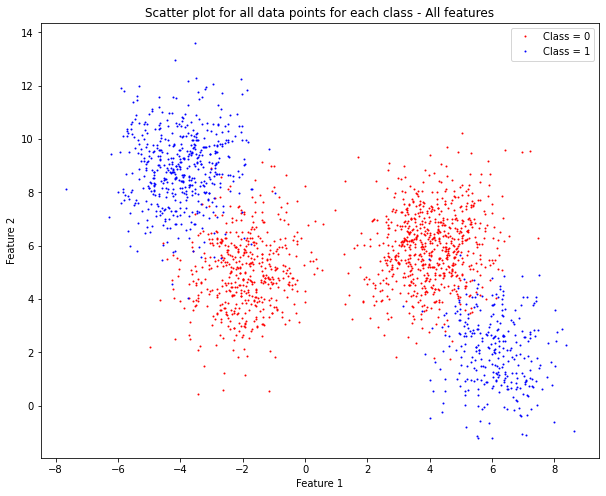

In [8]:
### Scatter plot for all points for each class - All features ###
class_1_feature_0 = class_1[ : , 0]
class_1_feature_1 = class_1[ : , 1]
class_0_feature_0 = class_0[ : , 0]
class_0_feature_1 = class_0[ : , 1]

plt.plot(class_0_feature_0, class_0_feature_1, "ro", ms=1, mec='r', label = "Class = 0")
plt.plot(class_1_feature_0, class_1_feature_1, "ro", ms=1, mec='b', label = "Class = 1")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Scatter plot for all data points for each class - All features") 
plt.legend()
plt.show()

## Logistic Regression

Here we will implement the Logistic Regression algorithm that uses gradient descent for finding the optimal theta vector. 

Where:
$$
h_\theta(x) = \frac{1}{1 + e^{-\theta^T x}}
$$

$$
J(\theta)=\frac{1}{m} \sum_{d=1}^{m} - y^{(d)}ln(h_\theta(x^{(d)}) - (1 - y^{(d)})ln(1 - h_\theta(x^{(d)})
$$

Our class contains the following functions:
1. fit - the learning function
1. predict - the function for predicting an instance after the fit function was executed

Your model will also store a list of the costs that we've calculated in each iteration

In [9]:
class LogisticRegressionGD(object):
    """
    Logistic Regression Classifier using gradient descent.

    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    eps : float
      minimal change in the cost to declare convergence
    random_state : int
      Random number generator seed for random weight
      initialization.
    """
    
    def __init__(self, eta=0.00005, n_iter=10000, eps=0.000001, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.eps = eps
        self.random_state = random_state
        self.theta = np.array([]) # avoid changing the original thetas
        self.cost_history = []
        
    def h_0(self, x):
        e_power = -1 * np.dot(x, self.theta)
        return 1 / (1 + np.exp(e_power))
        
    def compute_cost(self, X, y):
        """
        Computes the average squared difference between an obserbation's actual and
        predicted values for linear regression.  

        Input:
        - X: inputs  (n features over m instances).
        - y: true labels (1 value over m instances).
        - theta: the parameters (weights) of the model being learned.

        Returns a single value:
        - J: the cost associated with the current set of parameters (single number).
        """
        h_x = self.h_0(X)
        sigma = np.sum((-y @ np.log(h_x)) - ((1 - y) @ np.log(1 - h_x)))   # sigma according to cost function
        return sigma / len(X)
        
    def fit(self, X, y):
        """ 
        Fit training data (the learning phase).
        Updating the theta vector in each iteration using gradient descent.
        Store the theta vector in an attribute of the LogisticRegressionGD object.
        Stop the function when the difference between the previous cost and the current is less than eps
        or when you reach n_iter.
        
        Parameters
        ----------
        X : {array-like}, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.

        """
      
        new_X = np.column_stack((np.ones(len(X)),X.copy()))   # concatanating a column of ones to the data(X)
        np.random.seed(self.random_state)
        self.theta = np.random.random(size=new_X.shape[1]) # set first theta to random value
        J_history = [] # Use a list to save cost in every iteration
        
        for i in range(self.n_iter):  # same process as gradient decent
            cost = self.compute_cost(new_X, y)
            J_history.append(cost) 
            if(i != 0 and (J_history[i-1] - J_history[i]) < self.eps):  # if improvement of the loss value is smaller than eps - stop process
                break   
            else:
                theta_fix = -self.eta * np.dot((self.h_0(new_X) - y), new_X) # calculate the delta of theta 
                self.theta += theta_fix # update the new value of theta

        self.cost_history = J_history   # update the cost history  

    def predict(self, X):
        """Return the predicted class label"""
        X = np.c_[np.ones(len(X)),X.copy()]    # concatanating a column of ones to matrix X(the copy of X)
        return (self.h_0(X) > 0.5).astype(int)
    

## Cross Validation

We will use 5-fold cross validation in order to find the best eps and eta params from the given lists.

We will shuffle the training set before we split the data to the folds.

In [10]:
### test_accuracy - function for checking accuracy of certain eps and eta ###
def test_accuracy(X_train, X_test, eps, eta):
    regression_obj = LogisticRegressionGD(eta, 10000, eps)
    X_train_label = X_train[:, -1]
    X_train_features = X_train[:, :-1]
    regression_obj.fit(X_train_features, X_train_label)
    return (regression_obj.predict(X_test[:, :-1]) == X_test[:, -1]).mean()

In [11]:
etas = [0.05, 0.005, 0.0005, 0.00005, 0.000005]
epss = [0.01, 0.001, 0.0001, 0.00001, 0.000001]


### shuflle data and create 5 folds out of data ###
train = training_set.values
np.random.shuffle(train)
size = len(train)
folds = []
for i in range(1, 6):
    start = int(size * (i - 1) / 5)  # start index of current fold
    end = int(size * i / 5)          # end index of current fold
    folds.append(train[start:end, :])# create sub-array and append to folds

max_accuracy = 0.0
max_eps_eta = []
for eta in etas:
    for eps in epss:
        temp_accuracy = 0.0
        for index_test in range(len(folds)):
            X_train_temp = [subset for index, subset in enumerate(folds) if index is not index_test] # crete list from all training data
            X_train_temp = [element for sublist in X_train_temp for element in sublist] # flatten all lists of training data
            X_train_temp = np.array(X_train_temp) # make an np array from train data
            temp_accuracy += test_accuracy(X_train_temp, folds[index_test], eps, eta) # send test data and train data to test_accuracy 
        temp_accuracy = temp_accuracy / 5.0
        if (temp_accuracy > max_accuracy): # save max accuracy and best hyper parameters
            max_accuracy = temp_accuracy
            max_eps_eta = [eps,eta]           
print("best epsilon :",max_eps_eta[0])
print("best eta :",max_eps_eta[1])
print("best accuracy :",max_accuracy)

best epsilon : 1e-06
best eta : 5e-05
best accuracy : 0.7805


## Normal distribution pdf

Here we will implement the normal distribution pdf 
$$
f(x;\mu,\sigma) = \frac{1}{\sigma\sqrt{2\pi}}e^{-\frac{1}{2}\big{(}\frac{x-\mu}{\sigma}\big{)}^2}
$$

In [12]:
# calc normal pdf    
def norm_pdf(data, mu, sigma):
    """
    Calculate normal desnity function for a given x, mean and standrad deviation.
 
    Input:
    - x: A value we want to compute the distribution for.
    - mean: The mean value of the distribution.
    - std:  The standard deviation of the distribution.
 
    Returns the normal distribution pdf according to the given mean and std for the given x.    
    """
    power_e = (-1/2) * np.power((data - mu) / sigma ,2)
    sqr_2pi =  np.power(2 * np.pi , 0.5)
    return np.exp(power_e) / (sigma * sqr_2pi)

## Expectation Maximization

Now we will implement the Expectation Maximization algorithm for gaussian mixture model.

The class holds the distribution params.

We use -log likelihood as the cost function:
$$
cost(x) = \sum_{d=1}^{m}-log(w * pdf(x; \mu, \sigma))
$$

In [13]:
class EM(object):
    """
    Naive Bayes Classifier using Gauusian Mixture Model (EM) for calculating the likelihood.

    Parameters
    ------------
    k : int
      Number of gaussians in each dimension
    n_iter : int
      Passes over the training dataset in the EM proccess
    eps: float
      minimal change in the cost to declare convergence
    random_state : int
      Random number generator seed for random params initialization.
    """
    
    def __init__(self, k=1, n_iter=1000, eps=0.01, random_state=42):
        self.k = k
        self.n_iter = n_iter
        self.eps = eps
        self.random_state = random_state
        self.weight = np.ones(self.k)
        self.responsibilities = []
        self.mu = np.ones(self.k)
        self.sigma = np.ones(self.k)
        self.cost_history = []
        
    # initial guesses for parameters
    def init_params(self, data):
        """
        Initialize distribution params
        """
        np.random.seed(self.random_state)
        
        for i in range(self.k):
            self.weight[i] = self.weight[i] / self.k
            self.mu[i] = np.random.random(1)
            self.sigma[i] =  np.random.random(1)

        
    def expectation(self, data):
        """
        E step - calculating responsibilities
        """ 
        self.responsibilities = np.empty(shape=(self.k, data.shape[0]))
        Sigma_sum_norm_pdf = 0
        for i in range(self.k):
            norm_pdf_index_k = norm_pdf(data, self.mu[i], self.sigma[i]) * self.weight[i]
            Sigma_sum_norm_pdf += norm_pdf_index_k
            self.responsibilities[i] = norm_pdf_index_k  
        self.responsibilities = self.responsibilities / Sigma_sum_norm_pdf
            
    def maximization(self, data):
        """
        M step - updating distribution params
        """ 
        size = len(data)
        self.expectation(data)

        for index_K in range(self.k):
            #update the new weights#
            self.weight[index_K] = np.sum(self.responsibilities[index_K], axis=0) / size
            
            #update the new mean#
            self.mu[index_K] = np.sum(data * self.responsibilities[index_K], axis=0) / (self.weight[index_K] * size)
           
            #update the new variance#
            instance_minus_mu = np.square(data - self.mu[index_K])
            Sigma_of_variance = np.sum(self.responsibilities[index_K] * instance_minus_mu, axis=0)
            self.sigma[index_K] = np.sqrt(Sigma_of_variance / (self.weight[index_K] * size))
    
    def compute_cost(self, data):
        return np.sum(-np.log(np.sum(self.responsibilities, axis = 0))) # calculate cost by the cost formula
    
    def fit(self, data):
        """ 
        Fit training data (the learning phase).
        Use init_params and then expectation and maximization function in order to find params 
        for the distribution. 
        Store the params in attributes of the EM object.
        Stop the function when the difference between the previous cost and the current is less than eps
        or when you reach n_iter.
        """
        J_history = [] # Use a list to save cost in every iteration
        cost = 0
        self.init_params(data)
        for i in range(self.n_iter):
            self.maximization(data) # M step - updating distribution params
            cost = self.compute_cost(data) # calculate cost on the data
            J_history.append(cost) # update the J history  
            if(i != 0 and (J_history[i-1] - cost) < self.eps):  # if improvement of the loss value is smaller than eps - stop process
                break

        self.cost_history = J_history  # update the cost history of the object  
        
    def get_dist_params(self):
        return self.mu, self.sigma, self.weight

## Naive Bayes

Here we will implement the Naive Bayes algorithm.

For calculating the likelihood we will use the EM algorithm that we implemented above to find the distribution params. With these params we can calculate the likelihood probability.

We calculate the prior probability directly from the training set.

In [14]:
class NaiveBayesGaussian(object):
    """
    Naive Bayes Classifier using Gauusian Mixture Model (EM) for calculating the likelihood.

    Parameters
    ------------
    k : int
      Number of gaussians in each dimension
    random_state : int
      Random number generator seed for random params initialization.
    """
    
    def __init__(self, k=1, random_state=42):
        
        self.k = k
        self.mu_class_0 = []
        self.mu_class_1 = []
        self.sigma_class_0 = []
        self.sigma_class_1 = []
        self.weights_class_0 = []
        self.weights_class_1 = []
        self.priors_of_classes = []
        self.class_values = []
        self.X_of_class_value_0 = []
        self.X_of_class_value_1 = []
        self.random_state = random_state
        
    def init_params(self, data, y):
        """
        Initialize params
        """
        self.weights_class_0 = np.empty(shape=(data.shape[1], self.k))
        self.weights_class_1 = np.empty(shape=(data.shape[1], self.k))
        self.mu_class_0 = np.empty(shape=(data.shape[1], self.k))
        self.mu_class_1 = np.empty(shape=(data.shape[1], self.k))
        self.sigma_class_0 = np.empty(shape=(data.shape[1], self.k))
        self.sigma_class_1 = np.empty(shape=(data.shape[1], self.k))
        self.X_of_class_value_0 = data[y == self.class_values[0]]
        self.X_of_class_value_1 = data[y == self.class_values[1]]
        
    def get_prior(self , y):
        """
        Returns the priors porbability of the classes according to the dataset distribution.
        """ 
        size_y = len(y)
        self.class_values, counts_of_instance_from_classes = np.unique(y, return_counts=True)
        self.priors_of_classes = counts_of_instance_from_classes / size_y
        
    
    def fit(self, X, y):
        """ 
        Fit training data.

        Parameters
        ----------
        X : array-like, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.
        """
        self.get_prior(y) # Update the priors porbability of the classes according to the dataset distribution 
        self.init_params(X, y)
        object_em = EM(self.k, 1000, 0.01, self.random_state)
       
    #calculate the params(mu,sigma,weight) for each feature for the 2 classes# 
        for index_feature in range(X.shape[1]):
            object_em.fit(self.X_of_class_value_0[:,index_feature])
            self.mu_class_0[index_feature], self.sigma_class_0[index_feature], self.weights_class_0[index_feature] = object_em.get_dist_params()
            object_em.fit(self.X_of_class_value_1[:,index_feature])
            self.mu_class_1[index_feature], self.sigma_class_1[index_feature], self.weights_class_1[index_feature] = object_em.get_dist_params()
        
    def get_instance_likelihood(self, X, mu_class, sigma_class, weights_class):
        """
        Returns the likelihhod porbability of the instance under the class according to the dataset distribution.
        """
        likelihood = 1
        #calculate the likelihood for each feature(in each gaussian)#
        for index_feature in range(X.shape[0]):
            pdf_naive = 0
            for index_K in range(self.k):
                pdf_naive+= norm_pdf(X[index_feature], mu_class[index_feature,index_K], sigma_class[index_feature,index_K]) * weights_class[index_feature,index_K]
            likelihood*= pdf_naive   
        return likelihood
            
 
    def predict(self, X):
        """Return the predicted class label"""
        pred_data_class = []
        pred_class_0, pred_class_1 = 0, 0
        
        #calculate the prediction for each instance on the two classes and find the higher#
        for instance in X:
            pred_class_0 = self.priors_of_classes[0] * self.get_instance_likelihood(instance, self.mu_class_0, self.sigma_class_0, self.weights_class_0)
            pred_class_1 = self.priors_of_classes[1] * self.get_instance_likelihood(instance, self.mu_class_1, self.sigma_class_1, self.weights_class_1)
            if(pred_class_0 > pred_class_1):
                pred_data_class.append(self.class_values[0])
            else:
                pred_data_class.append(self.class_values[1])
        return np.array(pred_data_class)   

## Model evaluation
In this section we will build 2 models and fit them to 2 datasets

First 1000 training points and first 500 test points:
1. We will use the first 1000 points from the training set and the first 500 points from the test set.
1. We will fit Logistic Regression model with the best params we found earlier.
1. We will fit Naive Bayes model.
1. We will print the training and test accuracies for each model.
1. We will use the `plot_decision_regions` function to plot the decision boundaries for each model 
1. We will plot the cost Vs the iteration number for the Logistic Regression model

We will use all the training set points:
1. We will repeat sections 2-6 for all the training set points
1. We will provide one or two sentences on each graph explaining what you observe in the graph.

In [15]:
def accuracy(X,y, object_model):
### accuracy - function for checking accuracy of the object model ###
    return (object_model.predict(X) == y).mean()

accuracy for first 1000 points training set in Logistic Regression: 0.965
accuracy for first 500 points test set in Logistic Regression: 0.938
accuracy for first 1000 points training set in Naive Bayes: 0.966
accuracy for first 500 points test set in Naive Bayes: 0.942


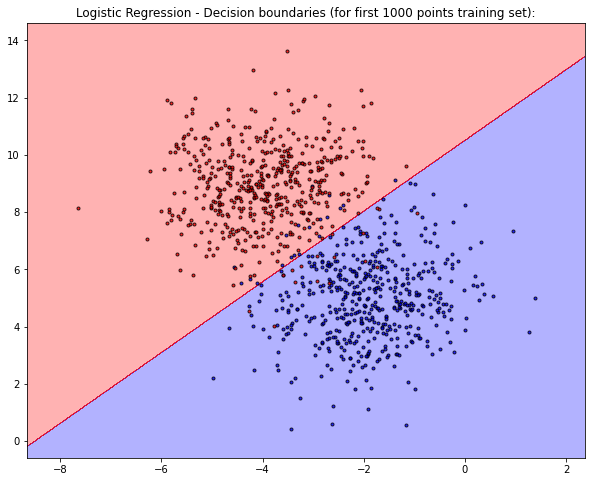

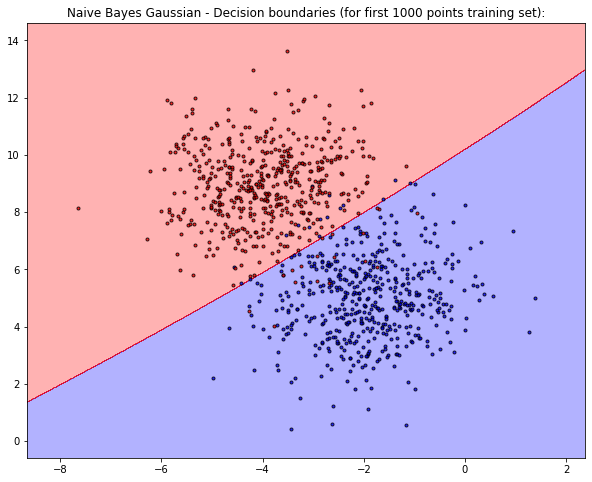

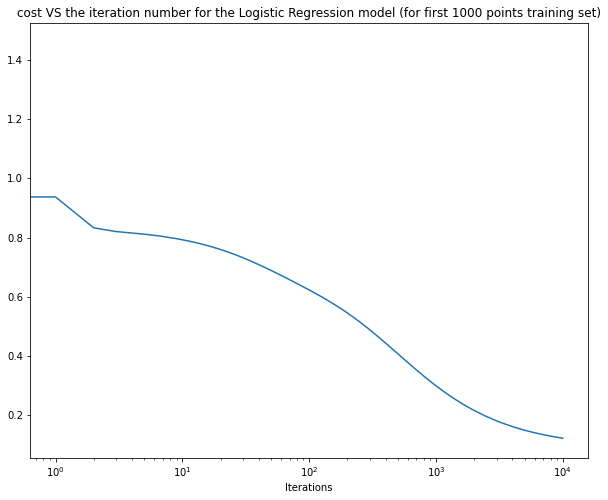

In [16]:
#*****1*****#
training_data_first1000 = X_training[ : 1000]
training_data_first1000_label = y_training[ : 1000]

test_data_first500 = X_test[ : 500]
test_data_first500_label = y_test[ : 500]

#*****2*****#

#fit LogisticRegressionGD#
object_LogisticRegressionGD_1000 = LogisticRegressionGD(eta=max_eps_eta[1], n_iter=10000, eps=max_eps_eta[0], random_state= 1)
object_LogisticRegressionGD_1000.fit(training_data_first1000, training_data_first1000_label)

#*****3*****#

#fit NaiveBayesGaussian#
object_NaiveBayesGaussian_1000 = NaiveBayesGaussian(k=1)
object_NaiveBayesGaussian_1000.fit(training_data_first1000, training_data_first1000_label)

#*****4*****#

#accuracy for training and test data in LogisticRegression#
print("accuracy for first 1000 points training set in Logistic Regression:", accuracy(training_data_first1000, training_data_first1000_label, object_LogisticRegressionGD_1000))
print("accuracy for first 500 points test set in Logistic Regression:",accuracy(test_data_first500, test_data_first500_label, object_LogisticRegressionGD_1000))

#accuracy for training and test data in NaiveBayes#
print("accuracy for first 1000 points training set in Naive Bayes:", accuracy(training_data_first1000, training_data_first1000_label, object_NaiveBayesGaussian_1000))
print("accuracy for first 500 points test set in Naive Bayes:",accuracy(test_data_first500, test_data_first500_label, object_NaiveBayesGaussian_1000))

#*****5*****#

#Logistic Regression - Decision boundaries#
plot_decision_regions(training_data_first1000, training_data_first1000_label, object_LogisticRegressionGD_1000)
plt.title("Logistic Regression - Decision boundaries (for first 1000 points training set):")
plt.show()

#Naive Bayes Gaussian - Decision boundaries#
plot_decision_regions(training_data_first1000, training_data_first1000_label, object_NaiveBayesGaussian_1000)
plt.title("Naive Bayes Gaussian - Decision boundaries (for first 1000 points training set):")
plt.show()

#*****6*****#

cost_values = object_LogisticRegressionGD_1000.cost_history
plt.plot(list(range(len(cost_values))), cost_values)
plt.xscale("log")
plt.xlabel("Iterations")
plt.title("cost VS the iteration number for the Logistic Regression model (for first 1000 points training set)")
plt.show()

accuracy for all training set in Logistic Regression: 0.809
accuracy for all test set in Logistic Regression: 0.804
accuracy for all training set in Naive Bayes: 0.885
accuracy for all test set in Naive Bayes: 0.873


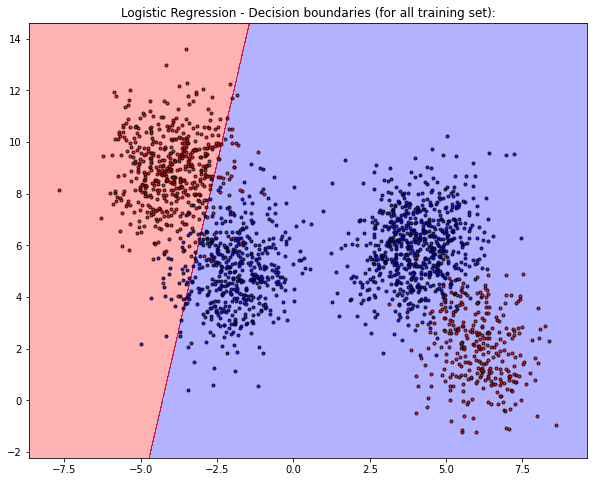

In this graph we can see that the instances are distributed in a way such that there is no linear seperator.
Therefore, when the Logistic Regression creates a linear seperator it does not
seperate the data properly (because it is not linearly seperable).


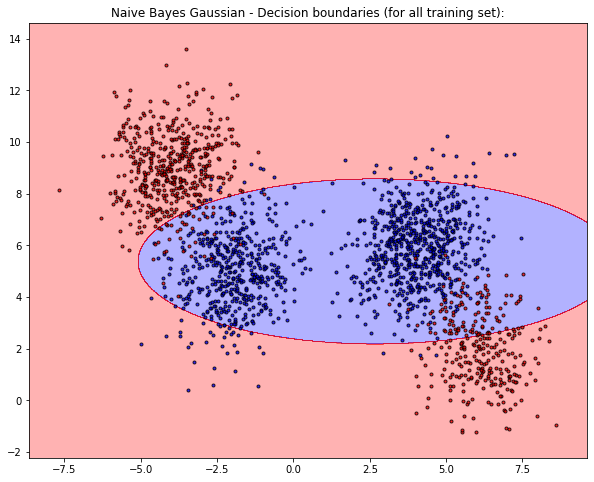

In this graph we can see that the Naive Bayes algorithm creates a good seperation on the data,
becuase it is not a linear seperation. This is because the Naive Bayes uses the EM algorithm to find the weight,
mu and sigma of each gaussian in each label, and seperates the data using these variables. 


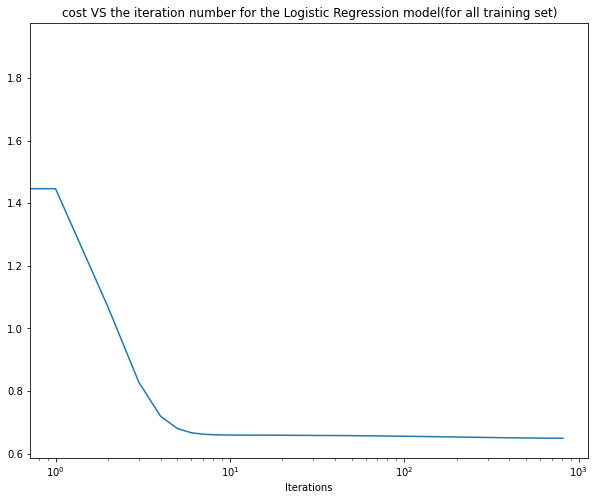

In this graph we can see that the more iterations we do - the cost reduces. This process is the same as 
in Gradient Descent, the more instances we process, the closer we get to the theta that demonstrates the trend of the data.


In [17]:
#*****2*****#

#fit LogisticRegressionGD#
object_LogisticRegressionGD_all_data = LogisticRegressionGD(eta=max_eps_eta[1], n_iter=10000, eps=max_eps_eta[0], random_state= 1)
object_LogisticRegressionGD_all_data.fit(X_training, y_training)

#*****3*****#

#fit NaiveBayesGaussian#
object_NaiveBayesGaussian_all_data = NaiveBayesGaussian(k=2)
object_NaiveBayesGaussian_all_data.fit(X_training, y_training)

#*****4*****#

#accuracy for test data in LogisticRegression#
print("accuracy for all training set in Logistic Regression:", accuracy(X_training, y_training, object_LogisticRegressionGD_all_data))
print("accuracy for all test set in Logistic Regression:", accuracy(X_test, y_test, object_LogisticRegressionGD_all_data))

#accuracy for test data in NaiveBayes#
print("accuracy for all training set in Naive Bayes:", accuracy(X_training, y_training, object_NaiveBayesGaussian_all_data))
print("accuracy for all test set in Naive Bayes:", accuracy(X_test, y_test, object_NaiveBayesGaussian_all_data))

#*****5*****#

#Logistic Regression - Decision boundaries#
plot_decision_regions(X_training, y_training, object_LogisticRegressionGD_all_data)
plt.title("Logistic Regression - Decision boundaries (for all training set):")
plt.show()
print("""In this graph we can see that the instances are distributed in a way such that there is no linear seperator.
Therefore, when the Logistic Regression creates a linear seperator it does not
seperate the data properly (because it is not linearly seperable).""")

#Naive Bayes Gaussian - Decision boundaries#
plot_decision_regions(X_training, y_training, object_NaiveBayesGaussian_all_data)
plt.title("Naive Bayes Gaussian - Decision boundaries (for all training set):")
plt.show()
print("""In this graph we can see that the Naive Bayes algorithm creates a good seperation on the data,
becuase it is not a linear seperation. This is because the Naive Bayes uses the EM algorithm to find the weight,
mu and sigma of each gaussian in each label, and seperates the data using these variables. """)

#*****6*****#

cost_values = object_LogisticRegressionGD_all_data.cost_history
plt.plot(list(range(len(cost_values))), cost_values)
plt.xscale("log")
plt.xlabel("Iterations")
plt.title("cost VS the iteration number for the Logistic Regression model(for all training set)")
plt.show()
print("""In this graph we can see that the more iterations we do - the cost reduces. This process is the same as 
in Gradient Descent, the more instances we process, the closer we get to the theta that demonstrates the trend of the data.""")
